In [1]:
'''
Model parameters
'''
import random
import numpy as np
from tqdm import tqdm

M = 4 # Number of Spiking motifs
N = 60 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 4000
dt = 1
nrn_fr = 20 # hz
pg_fr = 4 # hz
background_noise_fr = 10 # h


np.random.seed(41)

In [2]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [3]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.rand(N,D,M)*1000
K_dense = (K_dense < nrn_fr).astype('int')
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.rand(M,T)*1000
B_dense = (B_dense < pg_fr).astype('int')
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.rand(N,T+D)*1000
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

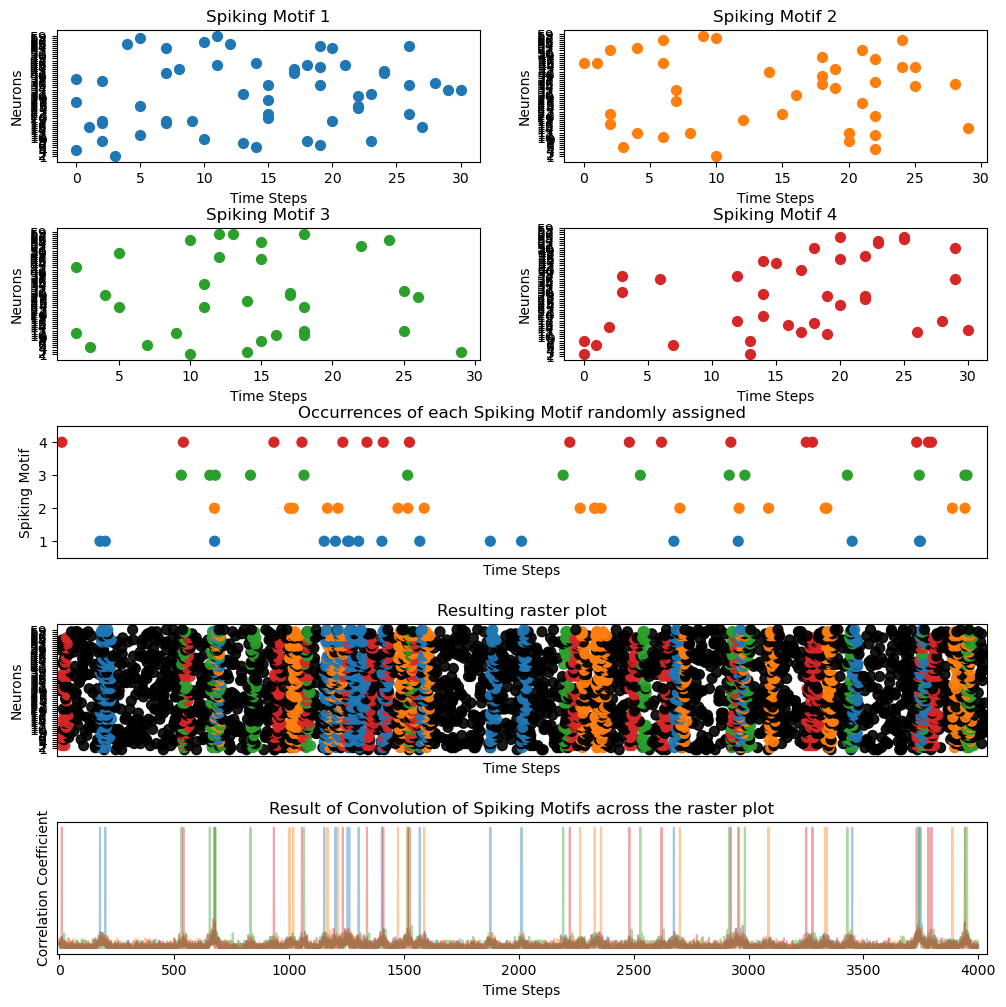

In [4]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 50

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


In [5]:
K_sparse

(array([ 1,  1,  1,  2,  2,  2,  2,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,
         7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 11, 11, 11, 11, 11, 12,
        12, 12, 12, 12, 12, 12, 13, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17,
        17, 18, 18, 18, 18, 18, 19, 19, 20, 21, 21, 21, 21, 23, 23, 23, 24,
        24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 30, 30,
        30, 30, 31, 31, 31, 32, 33, 33, 33, 34, 34, 35, 35, 35, 35, 35, 36,
        36, 36, 36, 37, 37, 37, 38, 39, 40, 41, 41, 41, 41, 42, 42, 42, 43,
        43, 43, 43, 43, 44, 44, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 47,
        47, 48, 49, 50, 50, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 54,
        55, 55, 55, 55, 55, 55, 56, 56, 56, 57, 58, 58, 58, 58, 58, 59],
       dtype=int64),
 array([ 3, 10, 10,  0, 13, 14, 29,  0,  3, 22,  3,  7, 14,  1,  7, 19, 13,
        15,  0,  2, 13, 18, 20, 23, 10,  6, 16, 18,  2,  5,  9, 19, 22,  4,
         8, 17, 18, 20, 25, 26, 30,  2, 29,  1, 16, 27,  2, 18,  2,  7

In [6]:
# Windowing the data
window_dim = int(50) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
N_labels = A_sparse[0].copy()
T_labels = A_sparse[1].copy()

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
N=max(N_labels)+1

windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window

In [332]:
plots = np.zeros(8**2,dtype='object')
plots[1:7] = np.arange(1,61)[:6]
plots[8:64-8] = np.arange(1,61)[6:60-6]
plots[64-8+1:64-8+1+6] = np.arange(1,61)[60-6:60+1]
plots -=1
plots

array([-1, 0, 1, 2, 3, 4, 5, -1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, -1, 54, 55, 56, 57, 58, 59, -1], dtype=object)

Plotting...


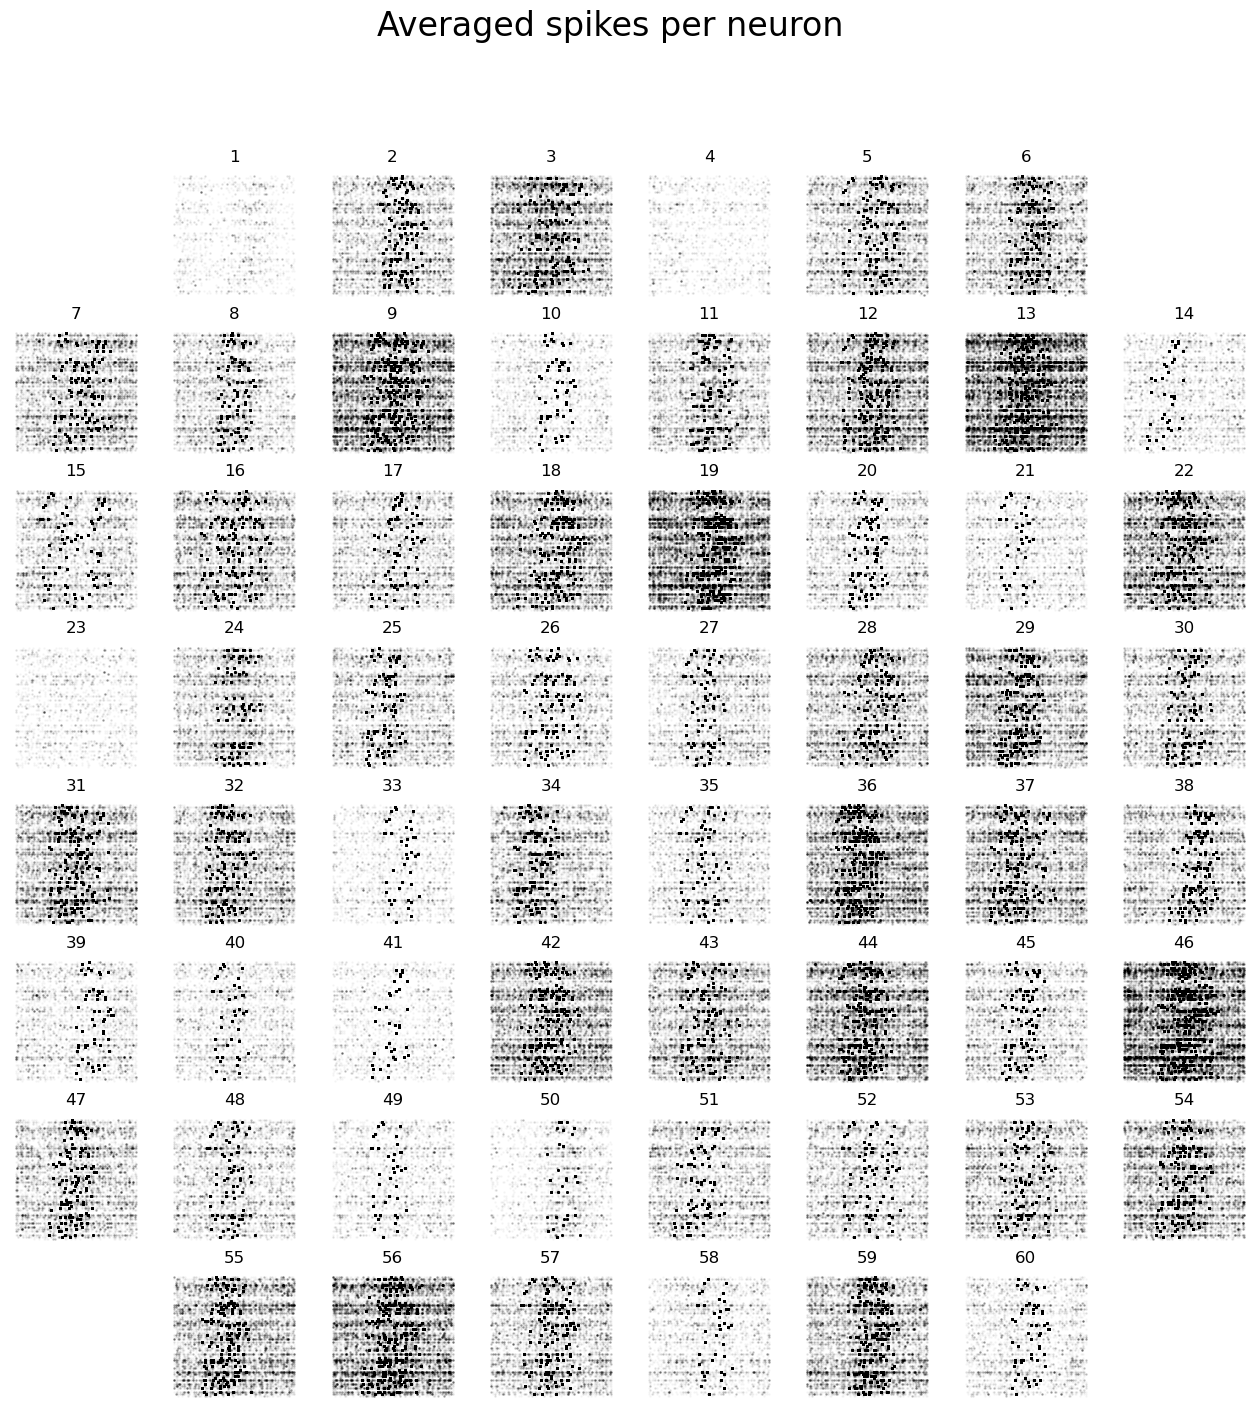

In [333]:

%matplotlib inline
fig, axs = plt.subplots(8, 8,  figsize=(16, 16))
i=0
for i,ax in enumerate(axs.flat):
    if plots[i] >=0:
        ax.scatter(*neighborhoods[plots[i]],c='black',s=1,alpha=0.01)
        ax.set_title(f'{plots[i]+1}')
    ax.axis('off')
fig.suptitle('Averaged spikes per neuron',fontsize=24)
print('Plotting...')
plt.show()
        
        

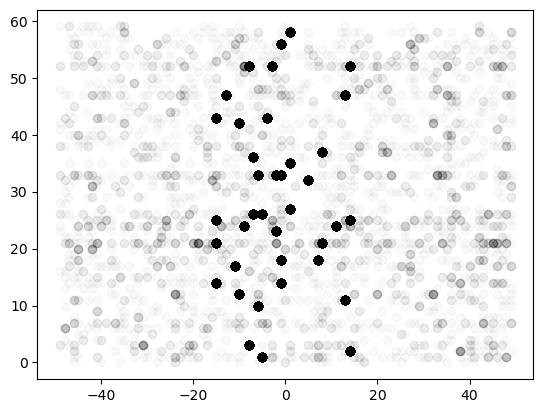

In [205]:
n=4
windows_n = windows[N_labels==n]
temp = []
for i in range(len(windows_n)):
    for j in range(len(windows_n)):
        if i != j:
            temp.append(windows_n[i].intersection(windows_n[j]))
temp = [k for k in temp if k != set()]
x2 = np.array([])
y2 = np.array([])
for t in temp:
    x2 = np.hstack((x2,np.array([k for k in t]).T[0]))
    y2 = np.hstack((y2,np.array([k for k in t]).T[1]))
plt.figure()
plt.scatter(x2,y2,c='black',alpha=0.01)
plt.show()

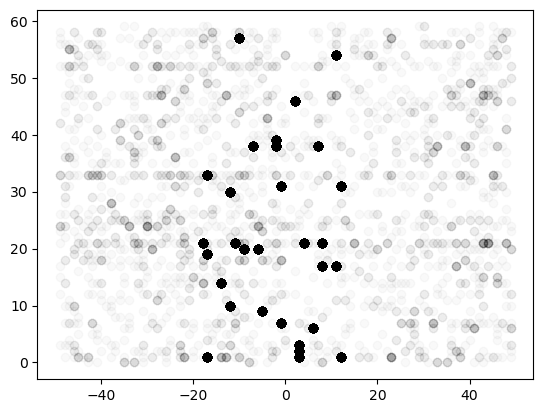

In [203]:
n=0
windows_n = windows[N_labels==n]
temp = []
for i in range(len(windows_n)):
    for j in range(len(windows_n)):
        if i != j:
            temp.append(windows_n[i].intersection(windows_n[j]))
temp = [k for k in temp if k != set()]
x1 = np.array([])
y1 = np.array([])
for t in temp:
    x1 = np.hstack((x1,np.array([k for k in t]).T[0]))
    y1 = np.hstack((y1,np.array([k for k in t]).T[1]))
plt.figure()
plt.scatter(x1,y1,c='black',alpha=0.01)
plt.show()

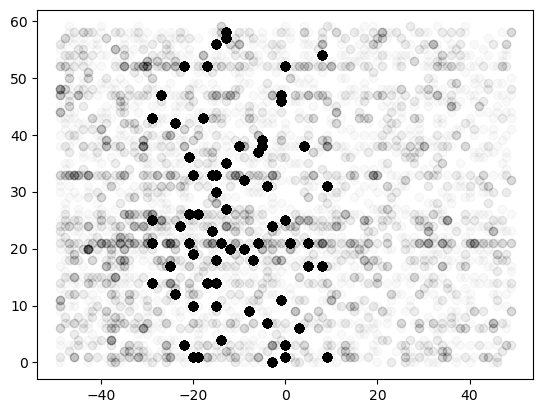

In [237]:
n=2
windows_n = windows[N_labels==n]
temp = []
for i in range(len(windows_n)):
    for j in range(len(windows_n)):
        if i != j:
            temp.append(windows_n[i].intersection(windows_n[j]))
temp = [k for k in temp if k != set()]
x = np.array([])
y = np.array([])
for t in temp:
    x = np.hstack((x,np.array([k for k in t]).T[0]))
    y = np.hstack((y,np.array([k for k in t]).T[1]))
plt.figure()
plt.scatter(x,y,c='black',alpha=0.01)
plt.show()

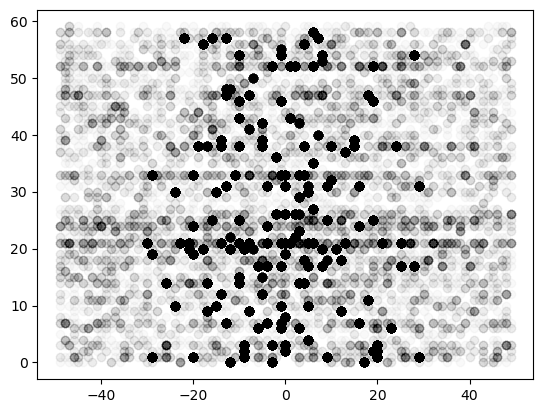

In [238]:
n=1
windows_n = windows[N_labels==n]
temp = []
for i in range(len(windows_n)):
    for j in range(len(windows_n)):
        if i != j:
            temp.append(windows_n[i].intersection(windows_n[j]))
temp = [k for k in temp if k != set()]
x = np.array([])
y = np.array([])
for t in temp:
    x = np.hstack((x,np.array([k for k in t]).T[0]))
    y = np.hstack((y,np.array([k for k in t]).T[1]))
plt.figure()
plt.scatter(x,y,c='black',alpha=0.01)
plt.show()

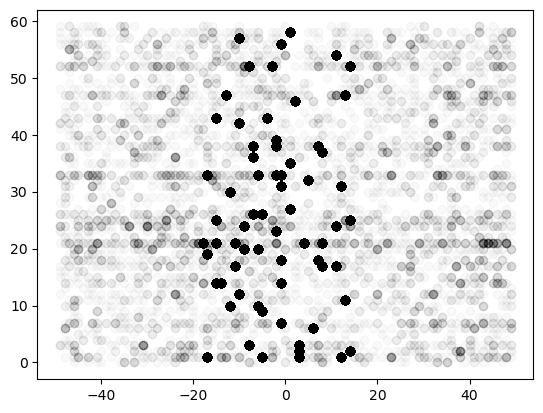

In [206]:
x3 = np.hstack((x1,x2))
y3 = np.hstack((y1,y2))
plt.figure()
plt.scatter(x3,y3,c='black',alpha=0.01)
plt.show()

In [334]:
def plot_neighborhood(T_labels,N_labels,alpha = 0.01):
    N=max(N_labels)+1

    windows = np.zeros((len(T_labels)),dtype='object')
    for i,window_time in enumerate(T_labels):
        condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
        window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
        window =  {tuple(row) for row in  window}
        windows[i] = window
    
    neighborhoods = np.zeros(N,dtype='object')
    for n in tqdm(range(N)):
        windows_n = windows[N_labels==n]
        all_points_n = []
        for i,w in enumerate(windows_n):
            w.remove((0,n))
            for j in range(len(windows_n)):
                if i!= j:
                    all_points_n.append(windows_n[i].intersection(windows_n[j]))
        all_points_n = [k for k in all_points_n if k!= set()]
        x = np.array([])
        y = np.array([])
        for points in all_points_n:
            x = np.hstack((x,np.array([k for k in points]).T[0]))
            y = np.hstack((y,np.array([k for k in points]).T[1]))
        neighborhoods[n] = np.array((x,y))
        
    plots = np.zeros(8**2,dtype='object')
    plots[1:7] = np.arange(1,61)[:6]
    plots[8:64-8] = np.arange(1,61)[6:60-6]
    plots[64-8+1:64-8+1+6] = np.arange(1,61)[60-6:60+1]
    plots -=1
    
    %matplotlib inline
    fig, axs = plt.subplots(8, 8,  figsize=(16, 16))
    i=0
    for i,ax in enumerate(axs.flat):
        if plots[i] >=0:
            ax.scatter(*neighborhoods[plots[i]],c='black',s=1,alpha=alpha)
            ax.set_title(f'{plots[i]+1}')
        ax.axis('off')
    fig.suptitle('Averaged spikes per neuron',fontsize=24)
    print('Plotting...')
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:04<00:00,  1.08s/it]


Plotting...


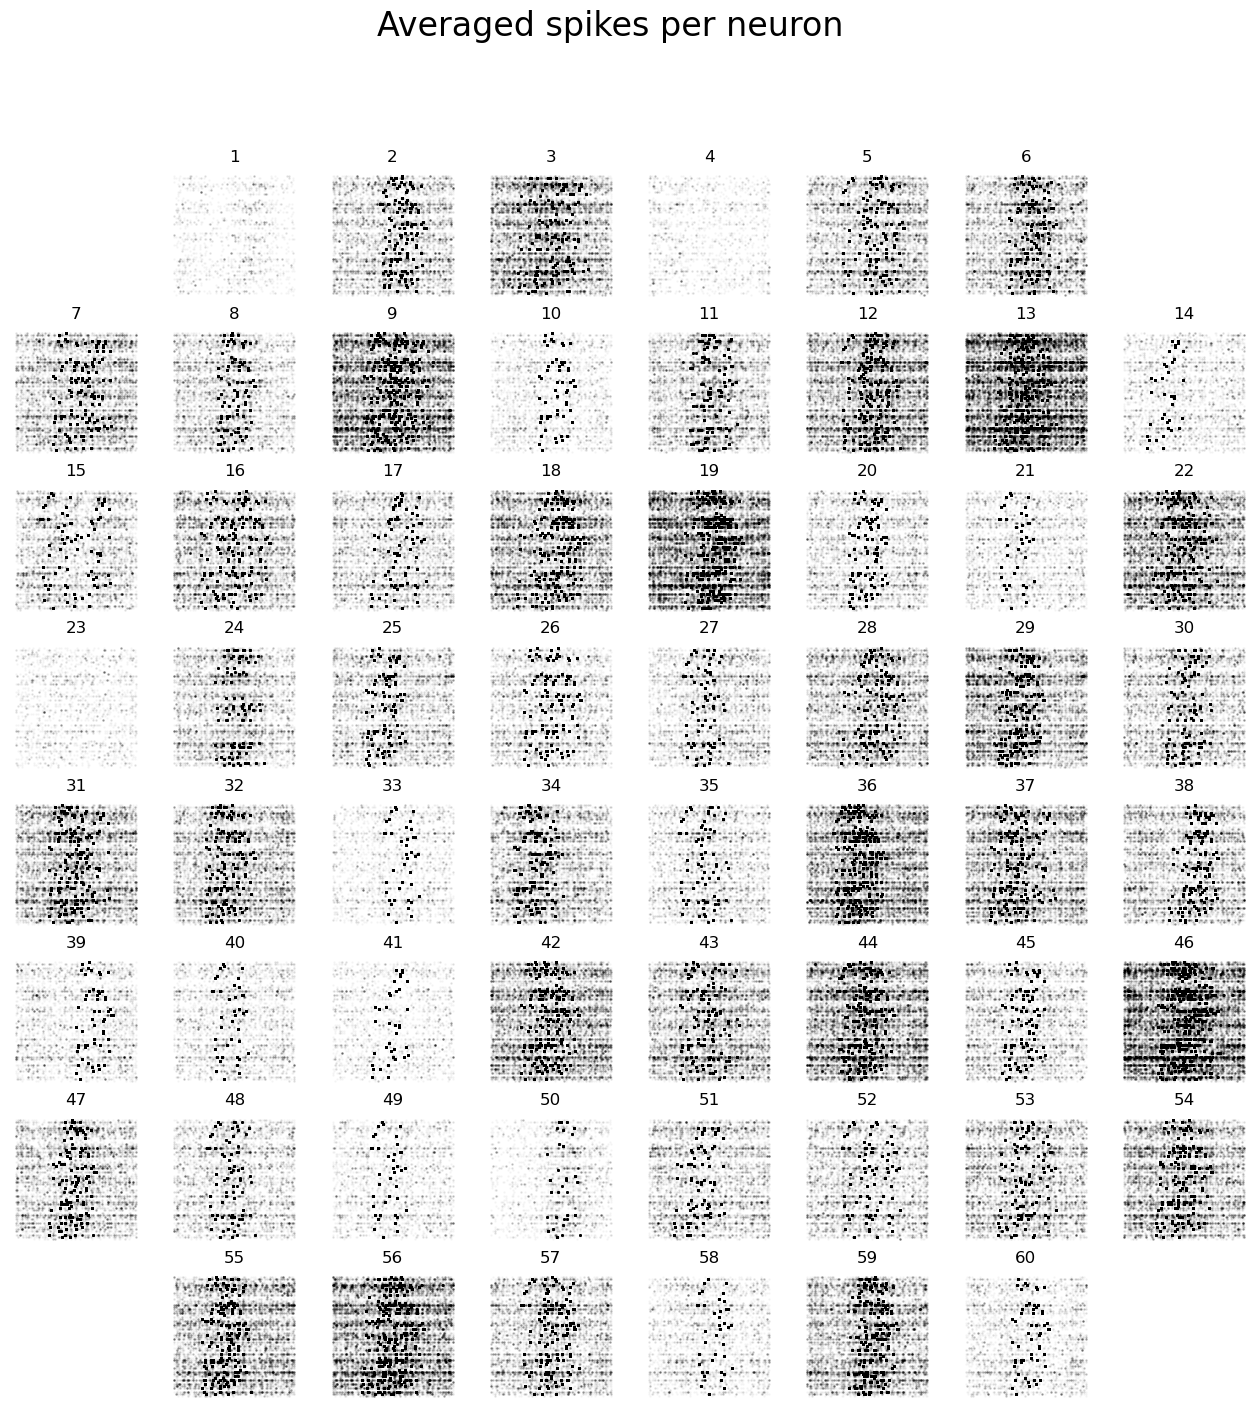

In [335]:
plot_neighborhood(T_labels,N_labels)

In [7]:
import neighborhood

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:09<00:00,  1.15s/it]


Plotting...


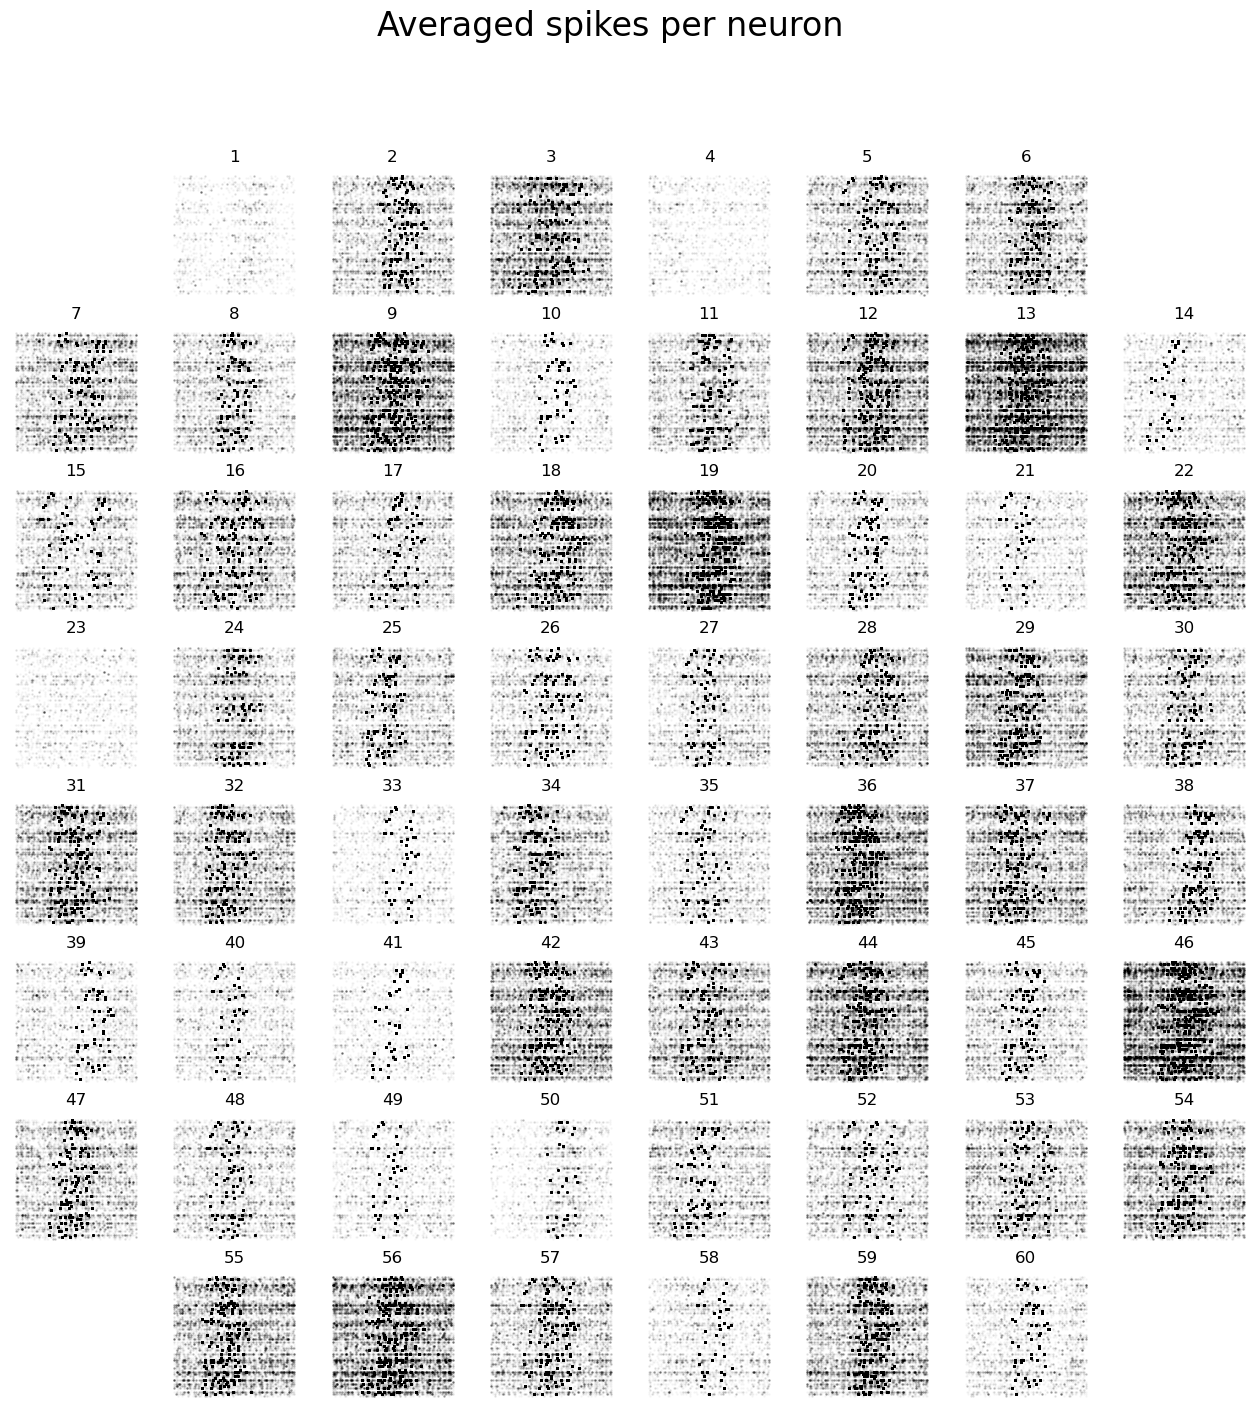

In [8]:
neighborhood.plot(T_labels,N_labels)